# Introduction
This notebook provides all code necessary for the submission of project 3. The outline follows the typical steps in any data wrangling process:

* Gathering data
* Assessing data
* Cleaning data

# Gathering data
For this project we use 3 sources of data:

1. WeRateDogs Twitter archive
2. Tweet image predictions
3. Each tweet's retweet count and favorite

Each of them will be loaded in pandas dataframes below.
First we load all the libraries.

In [1]:
import pandas as pd
import requests
import tweepy
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Twitter archive
The load the twitter_archive from the csv file provided

In [2]:
# Load the twitter_archive in a pandas dataframe
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

### Image predictions
Download the tweet image predictions file using the requests library

In [3]:
data = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image_predictions.tsv', 'wb') as f:
    f.write(data.content)

And load that file in a pandas dataframe

In [4]:
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

###  Tweet's retweet count and favorite
Next, Gather the additional data from the tweepy API.

In [22]:
consumer_key = 'xxxxxxxxxxxxx'
consumer_secret = 'xxxxxxxxxxxxx'
access_token = 'xxxxxxxxxxxxx-xxxxxxxxxxxxx'
access_secret = 'xxxxxxxxxxxxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

faulty_ids = []

#Loop over all tweet_id's we have
for t_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(t_id)
        # Append the data to the text file
        with open('tweet_json.txt', 'a') as js:
            json.dump(tweet._json, js)
            js.write('\n')
    except:
        faulty_ids.append(str(t_id))

print('Data extracted. Faulty ids {id_list}'.format(id_list=','.join(faulty_ids)))

This resulted in the tweet_json.txt. Some id's were missing or generated an error. These were:
[888202515573088257,873697596434513921,869988702071779329,861769973181624320,842892208864923648,802247111496568832,775096608509886464,676603393314578432,673887867907739649,672997845381865473,671520732782923777,668960084974809088]

Open the file back and read the data line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

In [5]:
# Generate list of dictionnaries to be used for generation of the pandas dataframe
tweet_list = []
with open('tweet_json.txt', 'r') as f:
    for line in f:
        dd = json.loads(line)
        tweet_list.append({'tweet_id':dd['id'], 'retweet_count':dd['retweet_count'], 'favorite_count':dd['favorite_count']})

twitter_extra = pd.DataFrame(tweet_list)

# Assessing data

An overview of the issues related to quality and tidiness is given below. The code used to define them is provided after the overview.


## Quality

* None in dog stage columns and name is not recognised as null value
* Timestamp is an object and no datetime
* 181 retweets in the twitter archive. We only want original ratings.
* 78 replies in the twitter archive. We only want original ratings.
* When multiple dogs are in the picture the denominator can be a multiplication of 10 for each dog in the picture
* Some numerators and denominators are wrong extracted (810984652412424192, 740373189193256964, 682962037429899265 & 666287406224695296)
* 2 numerators are equal to 0
* Image predictions are not always dogs


## Tidiness

* Dog "stage" columns, name and ratings are more linked to image predictions which would result in a table containing all information on the dogs
* retweet count and favourite count should be linked to the twitter archive


In [9]:
twitter_archive.head()
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [50]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
'\n'.join(twitter_archive[(twitter_archive['rating_denominator'] != 10) & ~(twitter_archive['in_reply_to_status_id'] > 0)& ~(twitter_archive['retweeted_status_user_id'] > 0)]['text'].values)

"The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd\nMeet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx\nWhy does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE\nAfter so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ\nSay hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv\nHappy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a\nThis is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq\nHappy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1\nHere's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7

In [7]:
twitter_archive[(twitter_archive['rating_denominator'] != 10) & ~(twitter_archive['in_reply_to_status_id'] > 0)& ~(twitter_archive['retweeted_status_user_id'] > 0)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None


In [17]:
twitter_archive[twitter_archive['rating_numerator'] == 0]['text'].values

array([ "When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag",
       "PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX"], dtype=object)

In [11]:
image_predictions.head()
image_predictions.info()
image_predictions.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.0+ KB


,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [12]:
twitter_extra.info()
twitter_extra.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 3 columns):
favorite_count    2344 non-null int64
retweet_count     2344 non-null int64
tweet_id          2344 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


,favorite_count,retweet_count,tweet_id
count,2344.000000,2344.000000,2.344000e+03
mean,8121.946246,3099.426621,7.426160e+17
std,12067.784755,5132.643935,6.840689e+16
min,0.000000,0.000000,6.660209e+17
25%,1416.750000,618.000000,6.784208e+17
50%,3589.500000,1451.000000,7.194596e+17
75%,10101.000000,3602.250000,7.989663e+17
max,131713.000000,78668.000000,8.924206e+17


# Cleaning data

## Missing data

*None in dog stage columns is not recognised as null value*

##### Define
Convert None in the columns doggo, floofer, pupper & puppo to NaN.

##### Code

In [6]:
twitter_archive_cleaned = twitter_archive.copy()
image_predictions_cleaned = image_predictions.copy()
twitter_extra_cleaned = twitter_extra.copy()

In [7]:
columns_to_replace = ['doggo', 'floofer', 'pupper', 'puppo', 'name']
# Iterate over the columns and change 'None' to a Nan value
for c in columns_to_replace:
    twitter_archive_cleaned[c].replace('None', np.nan, inplace=True)

##### test

In [8]:
twitter_archive_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1611 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
dtypes: float64(4), int64(3), object(10

## Tidiness

*Dog "stage" columns and name are more linked to image predictions which would result in a table containing all information on the dogs*

##### Define
Add the columns doggo, floofer, pupper, puppo, rating_numerator, rating_denominator and name to the image predictions dataframe. Rename the dataframe to doginfo

##### Code

In [9]:
# Merge dataframes
dog_info = image_predictions_cleaned.merge(twitter_archive_cleaned[['tweet_id', 'name', 'rating_numerator', 'rating_denominator', 'doggo', 'floofer', 'puppo', 'pupper']], on='tweet_id')
# drop columns from the twitter archive
twitter_archive_cleaned.drop(['name', 'rating_numerator', 'rating_denominator', 'doggo', 'floofer', 'puppo', 'pupper'],axis=1, inplace=True)

##### Test

In [10]:
dog_info.info()
twitter_archive_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
tweet_id              2075 non-null int64
jpg_url               2075 non-null object
img_num               2075 non-null int64
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null bool
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                2075 non-null bool
p3                    2075 non-null object
p3_conf               2075 non-null float64
p3_dog                2075 non-null bool
name                  1497 non-null object
rating_numerator      2075 non-null int64
rating_denominator    2075 non-null int64
doggo                 80 non-null object
floofer               8 non-null object
puppo                 24 non-null object
pupper                222 non-null object
dtypes: bool(3), float64(3), int64(4), object(9)
memory usage: 281.7+ KB
<class 'pandas.cor

*retweet count and favourite count should be linked to the twitter archive*

##### Define
Merge twitter_archive and twitter_extra dataframes

##### Code

In [11]:
# Merge
twitter_archive_cleaned = pd.merge(twitter_archive_cleaned, twitter_extra_cleaned, on='tweet_id')

##### Test

In [12]:
twitter_archive_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2343
Data columns (total 12 columns):
tweet_id                      2344 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2344 non-null object
source                        2344 non-null object
text                          2344 non-null object
retweeted_status_id           174 non-null float64
retweeted_status_user_id      174 non-null float64
retweeted_status_timestamp    174 non-null object
expanded_urls                 2285 non-null object
favorite_count                2344 non-null int64
retweet_count                 2344 non-null int64
dtypes: float64(4), int64(3), object(5)
memory usage: 238.1+ KB


## Quality

*Timestamp is an object and no datetime*

##### Define
Convert Timestamp column to datetime in the twitter_archive dataframe

##### Code

In [13]:
# Change type of column to datetime
twitter_archive_cleaned['timestamp'] = pd.to_datetime(twitter_archive_cleaned['timestamp'])

##### Test

In [14]:
twitter_archive_cleaned['timestamp'].dtype

dtype('<M8[ns]')

*181 retweets in the twitter archive. We only want original ratings.*

##### Define
Remove retweets from the twitter_archive dataframe

##### Code

In [15]:
twitter_archive_cleaned = twitter_archive_cleaned[~(twitter_archive_cleaned['retweeted_status_id']>0)]

##### Test

In [16]:
twitter_archive_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 0 to 2343
Data columns (total 12 columns):
tweet_id                      2170 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2170 non-null datetime64[ns]
source                        2170 non-null object
text                          2170 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2112 non-null object
favorite_count                2170 non-null int64
retweet_count                 2170 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 220.4+ KB


*78 replies in the twitter archive. We only want original ratings.*

##### Define
Remove replies from the twitter_archive dataframe

##### Code

In [17]:
twitter_archive_cleaned = twitter_archive_cleaned[~(twitter_archive_cleaned['in_reply_to_user_id']>0)]

##### Test

In [18]:
twitter_archive_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2343
Data columns (total 12 columns):
tweet_id                      2092 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2092 non-null datetime64[ns]
source                        2092 non-null object
text                          2092 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2089 non-null object
favorite_count                2092 non-null int64
retweet_count                 2092 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 212.5+ KB


*When multiple dogs are in the picture the denominator can be a multiplication of 10 for each dog in the picture*

##### Define
if the denominator is a multiple of 10, divide denominator and numerator to equal 10

##### Code

In [19]:
# First define a funtion that we can use in a apply. The function takes the row as input
def adapt_denominator(row):
    if row['rating_denominator'] % 10 == 0:
        factor = row['rating_denominator'] / 10
        row['rating_numerator'] /= factor
        row['rating_denominator'] /= factor
    return row

# Now apply the function
dog_info = dog_info.apply(adapt_denominator, axis=1)

##### Test

In [20]:
dog_info['rating_denominator'].value_counts()

10    2071
11       2
7        1
2        1
Name: rating_denominator, dtype: int64

*Some numerators and denominators are wrong extracted (810984652412424192, 740373189193256964, 682962037429899265 & 666287406224695296)*

##### Define
Manually correct numerators and denominators for the id's 810984652412424192, 740373189193256964, 682962037429899265 & 666287406224695296

##### Code

In [68]:
twitter_archive_cleaned[twitter_archive_cleaned['tweet_id'].isin([810984652412424192, 740373189193256964, 682962037429899265, 666287406224695296])]
# ID 810984652412424192 has no rating. Remove from both dataframes
twitter_archive_cleaned = twitter_archive_cleaned.loc[twitter_archive_cleaned['tweet_id'] != 810984652412424192]
dog_info = dog_info.loc[dog_info['tweet_id'] != 810984652412424192]
# Adapt the ratings for the others manually
dog_info.loc[dog_info['tweet_id'].isin([740373189193256964, 682962037429899265, 666287406224695296]),'rating_denominator'] = 10
dog_info.loc[dog_info['tweet_id'] == 740373189193256964, 'rating_numerator'] = 14
dog_info.loc[dog_info['tweet_id'] == 682962037429899265, 'rating_numerator'] = 10
dog_info.loc[dog_info['tweet_id'] == 666287406224695296, 'rating_numerator'] = 9






##### Test

In [76]:
dog_info[dog_info['tweet_id'].isin([810984652412424192, 740373189193256964, 682962037429899265, 666287406224695296])]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,name,rating_numerator,rating_denominator,doggo,floofer,puppo,pupper
20,666287406224695296,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,1,Maltese_dog,0.857531,True,toy_poodle,0.063064,True,miniature_poodle,0.025581,True,an,9,10,NaN,NaN,NaN,NaN
667,682962037429899265,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,1,dingo,0.278600,False,Chihuahua,0.155207,True,loupe,0.153598,False,Darrel,10,10,NaN,NaN,NaN,NaN
1196,740373189193256964,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True,NaN,14,10,NaN,NaN,NaN,NaN


*2 numerators are equal to 0*

##### Define
Remove these entries from the database

##### Code

In [92]:
# Get the id's to remove
ids_to_remove = dog_info[dog_info['rating_numerator'] == 0]['tweet_id'].values.tolist()
# Remove them
twitter_archive_cleaned = twitter_archive_cleaned.loc[~twitter_archive_cleaned['tweet_id'].isin(ids_to_remove)]
dog_info = dog_info.loc[~dog_info['tweet_id'].isin(ids_to_remove)]

##### Test

In [93]:
dog_info['rating_numerator'].value_counts()

12      478
10      432
11      419
13      284
9       152
8        94
7        50
14       41
5        34
6        32
3        19
4        15
2        10
1         4
75        1
26        1
420       1
27        1
15        1
1776      1
Name: rating_numerator, dtype: int64

*Image predictions are not always dogs*

##### Define
Make new column that contains the best image prediction that is a dog. 

##### Code

In [102]:
dog_info['breed'] = None

# Define function to apply. We seelect the first dog available
def get_dog_breed(row):
    if row['p1_dog']:
        row['breed'] = row['p1']
    elif row['p2_dog']:
        row['breed'] = row['p2']
    elif row['p3_dog']:
        row['breed'] = row['p3']
    return row
    
dog_info = dog_info.apply(get_dog_breed, axis=1)

##### Test

In [105]:
dog_info['breed'].value_counts()

golden_retriever               172
Labrador_retriever             113
Pembroke                        96
Chihuahua                       95
pug                             65
toy_poodle                      52
chow                            51
Samoyed                         46
Pomeranian                      42
malamute                        34
cocker_spaniel                  34
French_bulldog                  32
Chesapeake_Bay_retriever        31
miniature_pinscher              26
Cardigan                        23
Staffordshire_bullterrier       22
Eskimo_dog                      22
beagle                          21
German_shepherd                 21
Siberian_husky                  20
Shih-Tzu                        20
Lakeland_terrier                19
kuvasz                          19
Shetland_sheepdog               19
Maltese_dog                     19
Rottweiler                      19
Italian_greyhound               17
basset                          17
West_Highland_white_

# Analyzing, and Visualizing Data

## Save the cleaned datasets
The resulting datasets are written to csv files.

In [185]:
twitter_archive_cleaned.to_csv('twitter_archive_master.csv', index=False)
dog_info.to_csv('dog_info.csv', index=False)

## Analyse the dataset
The top 3 most rated dog breeds are:
* Saluki
* Pomeranian
* Tibatan_mastiff

The 3 least rated dog breeds are:
* soft-coated_wheaten_terrier
* Walker_hound
* Tibetan_terrier

These are calculated on dog breeds which occur at least 3 times in the database.

In [189]:
grouped = dog_info.groupby(by='breed')['rating_numerator'].aggregate(['mean', 'count'])
grouped[grouped['count']>2].sort_values('mean', ascending=False)[:3]
grouped[grouped['count']>2].sort_values('mean', ascending=True)[:3]

,mean,count
breed,,
Saluki,12.50000,4
Pomeranian,12.47619,42
Tibetan_mastiff,12.40000,5


In [160]:
full_dataset = dog_info.merge(twitter_archive_cleaned, how='inner', on='tweet_id')

For the next analysis a comparison is made between the ratings for each dog breed and the favorite / retweet count. The picture then looks different. The top 3 most reteweed dogs are:
* Bedlington_terrier
* Afghan_hound
* standard_poodle

The top 3 most favorited dogs are:
* Saluki
* Bedlington_terrier
* French_bulldog

The top 3 most added dogs are:
* golden_retriever
* Labrador_retriever
* Pembroke

In [183]:
grouped_full = full_dataset.groupby(by='breed')['rating_numerator', 'favorite_count', 'retweet_count'].aggregate(['mean', 'count'])
grouped_full = grouped_full[grouped_full['rating_numerator']['count']>2]
grouped_full.sort_values([('retweet_count', 'mean')], ascending=False)
grouped_full.sort_values([('favorite_count', 'mean')], ascending=False)
grouped_full.sort_values([('favorite_count', 'count')], ascending=False)

rating_numerator       favorite_count        \
                                        mean count           mean count   
breed                                                                     
golden_retriever                   11.567742   155   12509.187097   155   
Labrador_retriever                 11.198113   106   11836.160377   106   
Pembroke                           11.425532    94   11067.159574    94   
Chihuahua                          10.505618    89    8271.842697    89   
pug                                10.241935    62    6139.064516    62   
toy_poodle                         11.000000    50    6686.780000    50   
chow                               11.404255    47    9627.851064    47   
Samoyed                            11.690476    42   13788.357143    42   
Pomeranian                         12.600000    40    7923.800000    40   
malamute                           10.878788    33   10775.333333    33   
French_bulldog                     11.193548    31   18665.935484    31   
Chesapeake_Bay_retriever           10.866667    30   10315.366667    30   
cocker_spaniel                     11.333333    30   13741.900000    30   
miniature_pinscher                 10.041667    24    8223.041667    24   
Eskimo_dog                         11.409091    22   10590.090909    22   
Cardigan                           11.142857    21   12728.714286    21   
German_shepherd                    11.000000    21   10268.142857    21   
beagle                             10.150000    20    4366.250000    20   
Staffordshire_bullterrier          10.750000    20    9404.600000    20   
Shih-Tzu                           10.350000    20    3557.200000    20   
Siberian_husky                     11.250000    20    6952.200000    20   
Maltese_dog                         9.736842    19    2932.000000    19   
Rottweiler                         11.000000    18    7335.777778    18   
Shetland_sheepdog                  10.388889    18    8509.277778    18   
Lakeland_terrier                   10.235294    17   11849.529412    17   
kuvasz                             11.529412    17    5182.117647    17   
basset                             10.705882    17   11677.529412    17   
Italian_greyhound                  10.000000    17    8292.352941    17   
West_Highland_white_terrier        10.187500    16    6006.812500    16   
Great_Pyrenees                     11.466667    15   12341.400000    15   
...                                      ...   ...            ...   ...   
Norfolk_terrier                    11.333333     6    5780.166667     6   
Bedlington_terrier                 10.333333     6   21069.666667     6   
redbone                            10.200000     5    3891.600000     5   
Lhasa                              10.400000     5    2634.200000     5   
bull_mastiff                       10.400000     5    6021.600000     5   
Walker_hound                        9.000000     5    6526.600000     5   
miniature_schnauzer                 9.600000     5    3380.600000     5   
Norwich_terrier                     9.600000     5   10713.400000     5   
keeshond                           10.250000     4    4873.000000     4   
Scottish_deerhound                  9.750000     4    2281.500000     4   
Saluki                             12.500000     4   23895.000000     4   
Gordon_setter                      11.750000     4    5478.750000     4   
bluetick                           10.500000     4    4987.250000     4   
Ibizan_hound                        9.250000     4    3243.250000     4   
Weimaraner                         11.000000     4   11889.500000     4   
Tibetan_terrier                     9.250000     4    1820.250000     4   
Tibetan_mastiff                    12.250000     4   12068.250000     4   
Irish_setter                       11.750000     4   10489.750000     4   
Rhodesian_ridgeback                 9.750000     4    4012.000000     4   
Irish_water_spaniel                11.333333     3   

## Visualise the dataset

The analysis above indicates that ratings, retweets and favorites do not always seem to match. This is investiged further in the following visual assessement. Additionnally the correlation coefficients are determined.

Both the visual assessement as well as the correlation analysis show a significant correlation between the ratings and favorite and retweet counts. This correlation is more obvious with the favorite count compared to the retweet count.

rating_numerator           favorite_count            \
                                   mean     count           mean     count   
rating_numerator mean          1.000000  0.234360       0.501211  0.234360   
                 count         0.234360  1.000000       0.153628  1.000000   
favorite_count   mean          0.501211  0.153628       1.000000  0.153628   
                 count         0.234360  1.000000       0.153628  1.000000   
retweet_count    mean          0.419066  0.187207       0.927658  0.187207   
                 count         0.234360  1.000000       0.153628  1.000000   

                       retweet_count            
                                mean     count  
rating_numerator mean       0.419066  0.234360  
                 count      0.187207  1.000000  
favorite_count   mean       0.927658  0.153628  
                 count      0.187207  1.000000  
retweet_count    mean       1.000000  0.187207  
                 count      0.187207  1.000000

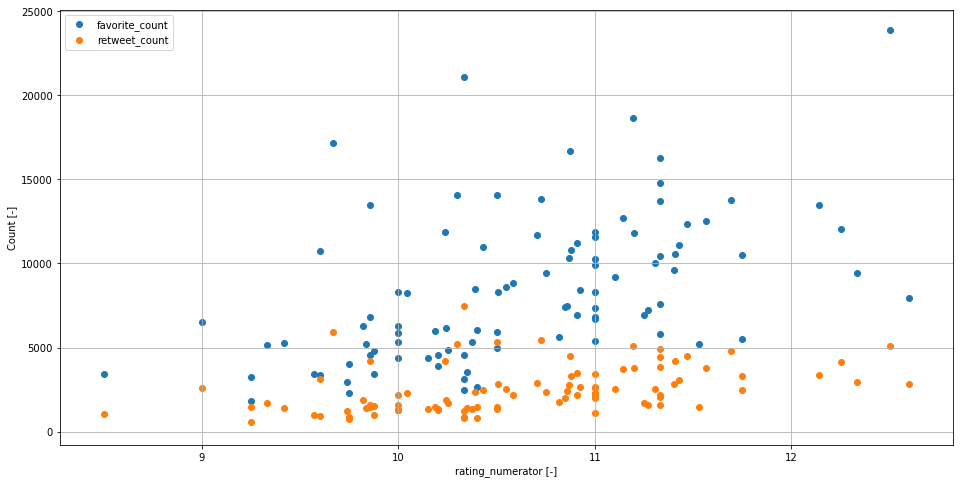

In [184]:
plt.figure(figsize=(16, 8))
plt.scatter(x=grouped_full['rating_numerator']['mean'], y=grouped_full['favorite_count']['mean'])
plt.scatter(x=grouped_full['rating_numerator']['mean'], y=grouped_full['retweet_count']['mean'])
plt.legend(['favorite_count', 'retweet_count'])
plt.grid()
plt.xlabel('rating_numerator [-]')
plt.ylabel('Count [-]')
grouped_full.corr()